<a href="https://colab.research.google.com/github/junaid1729/Ezitech_internship/blob/main/Task04/titanic_survival_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Name: Muhammad Junaid Iftikhar
# Roll Number: Ezi-ML-B1-161
# Shift Time: 3:00 PM - 6:00 PM
# Internship Type: hybird

# TASK 03 Regression Analysis

# DATASET USED: Titanic data set link : https://www.kaggle.com/datasets/yasserh/titanic-dataset

**Importing all dependecies for the project**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    confusion_matrix,roc_curve,roc_auc_score,precision_recall_curve,average_precision_score
)
import warnings
warnings.filterwarnings('ignore')


**Metrics computation helper**

In [ ]:
def compute_metrics_from_confusion_matrix(cm):
    TN,FP,FN,TP = cm.ravel()
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1_score = 2*precision*recall/(precision+recall) if (precision+recall)>0 else 0.0
    specificity = TN/(TN+FP) if (TN+FP)>0 else 0.0
    npv = TN/(TN+FN) if (TN+FN)>0 else 0.0
    fnr = FN/(TP+FN) if (TP+FN)>0 else 0.0
    fpr = FP/(TN+FP) if (TN+FP)>0 else 0.0

    return {
          "accuracy " : accuracy,
          "recall (sensitivity)" : recall,
          "precision ": precision,
          "f1 score " :f1_score,
          "specificity": specificity,
          "negative prediction rate": npv,
          "False negative rate": npv,
          "False positive rate": npv,
          "True Positive": TP,
          "True Negative": TN,
          "False Positive": FP,
          "False Negative": FN,
    }


**Reading csv file**

In [ ]:
df = pd.read_csv("Titanic-Dataset - Copy.csv")

**Dropping redundant/ high cardinality and duplicate and raw scaled features**

In [ ]:
to_drop = [
    'PassengerId','Name','Ticket','Cabin','PassengerId_LE','Name_LE','Ticket_LE','Cabin_LE',
    'Age_scaled','Fare_scaled','SibSp_scaled','Parch_scaled'
]

df.drop(columns=to_drop,inplace=True) # changing in orignal data frame


**Feature Engineering**

In [ ]:
df['IsAlone'] = (df['FamilySize']==1).astype(int)
df['AgeGroup']=pd.cut(df['Age'], bins=[0,12,18,60,100],
                       labels= ['Child','Teen','Adult','Senior'])
df['FareGroup']= pd.qcut(df['Fare'], q=4, labels=['Low','Medium','High','VeryHigh'])
df['IsMale']= (df['Sex']=='male').astype(int)



**Categorical Encoding**

In [ ]:
title_counts = df['Title'].value_counts()
rare_titles = title_counts[title_counts < 10].index
df['Title'] = df['Title'].apply(lambda x: 'Rare' if x in rare_titles else x)
cat_cols = ['Deck','Embarked','Title','AgeGroup','FareGroup']
df_encoded = pd.get_dummies(df[cat_cols],drop_first=True)

**Numerical Features**

In [ ]:
num_cols = ['Age','Fare']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[num_cols])
df_scaled = pd.DataFrame(scaled_features, columns=[f"{col}_scaled" for col in num_cols])

**Combining Features**

In [ ]:
final_features = pd.concat([
    df[['Pclass','IsMale','FamilySize','IsAlone','Survived']],
    df_encoded,
    df_scaled
],axis=1)

**Tran test split**

In [ ]:
X = final_features.drop('Survived',axis=1)
Y = final_features['Survived']
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42,stratify=Y)

print("final shape: ",X_train.shape,X_test.shape)

final shape:  (712, 26) (179, 26)


**Baseline models ( no tuning)**

In [ ]:
# Logistic Regression baseline
lr_base = LogisticRegression(solver='liblinear',random_state=42)
lr_base.fit(X_train,Y_train)


# Decision Tree baseline
dt_base = DecisionTreeClassifier(random_state=42)
dt_base.fit(X_train,Y_train)

# predictions
lr_base_pred_y = lr_base.predict(X_test)
dt_base_pred_y = dt_base.predict(X_test)

#Probablities
lr_base_pred_prob = lr_base.predict_proba(X_test)[:,1]
dt_base_pred_prob = dt_base.predict_proba(X_test)[:,1]

# metrics

metrics_lr_base = compute_metrics_from_confusion_matrix(confusion_matrix(Y_test,lr_base_pred_y))
metrics_dt_base = compute_metrics_from_confusion_matrix(confusion_matrix(Y_test,dt_base_pred_y))

**Hyper paramter tuning with gridcv and K fold cross validation**

In [ ]:
cv_strategy = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

# logistic regression tuning

param_grid_lr = {
    'C':[0.01,0.1,1,10],
    'penalty':['l1','l2']
}

grid_lr = GridSearchCV(
    LogisticRegression(solver='liblinear',random_state=42),
    param_grid_lr,
    cv=cv_strategy,
    scoring='f1',
    n_jobs=-1
)

grid_lr.fit(X_train,Y_train)



# decision Tree tuning

param_grid_dt = {
    'max_depth':[3,5,7,None],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4]
}

grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_dt,
    cv=cv_strategy,
    scoring='f1',
    n_jobs=-1
)

grid_dt.fit(X_train,Y_train)

print("Best parameters for Logistic Regression:",grid_lr.best_params_)
print("Best parameters for Decision Tree:",grid_dt.best_params_)


Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l1'}
Best parameters for Decision Tree: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}


**Tuned Model Evaluation**

In [ ]:
lr_tuned = grid_lr.best_estimator_
dt_tuned = grid_dt.best_estimator_

lr_tuned_pred_y = lr_tuned.predict(X_test)
lr_tuned_pred_prob = lr_tuned.predict_proba(X_test)[:,1]
dt_tuned_pred_y = dt_tuned.predict(X_test)
dt_tuned_pred_prob = dt_tuned.predict_proba(X_test)[:,1]

metrics_lr_tuned = compute_metrics_from_confusion_matrix(confusion_matrix(Y_test,lr_tuned_pred_y))
metrics_dt_tuned = compute_metrics_from_confusion_matrix(confusion_matrix(Y_test,dt_tuned_pred_y))

**Metrics comparison Table**

In [ ]:
comparison_df = pd.DataFrame({
    'LR_Base': metrics_lr_base,
    'LR_Tuned': metrics_lr_tuned,
    'DT_Base': metrics_dt_base,
    'DT_Tuned': metrics_dt_tuned
})

display(comparison_df)


,LR_Base,LR_Tuned,DT_Base,DT_Tuned
accuracy,0.804469,0.826816,0.770950,0.826816
recall (sensitivity),0.695652,0.739130,0.695652,0.710145
precision,0.774194,0.796875,0.705882,0.816667
f1 score,0.732824,0.766917,0.700730,0.759690
specificity,0.872727,0.881818,0.818182,0.900000
negative prediction rate,0.820513,0.843478,0.810811,0.831933
False negative rate,0.820513,0.843478,0.810811,0.831933
False positive rate,0.820513,0.843478,0.810811,0.831933
True Positive,48.000000,51.000000,48.000000,49.000000
True Negative,96.000000,97.000000,90.000000,99.000000


**ROC Curves**

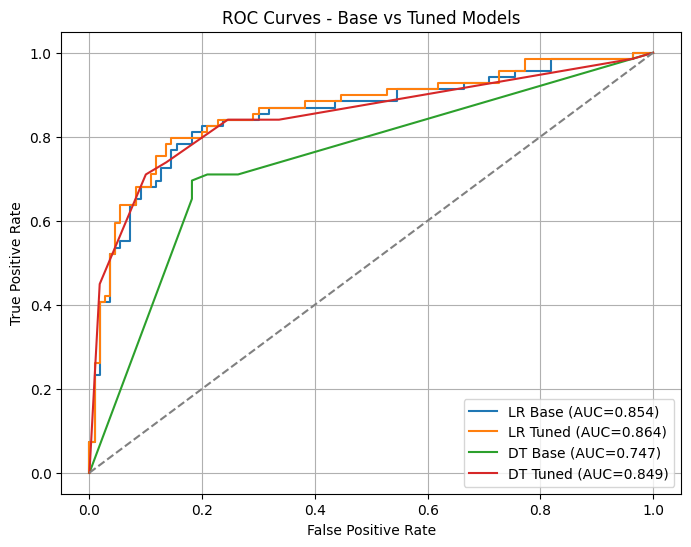

In [ ]:
plt.figure(figsize=(8,6))

#Logistic Regresion

fpr_lr_base,tpr_lr_base,_ = roc_curve(Y_test,lr_base_pred_prob)
fpr_lr_tuned,tpr_lr_tuned,_ = roc_curve(Y_test,lr_tuned_pred_prob)
auc_lr_base = roc_auc_score(Y_test,lr_base_pred_prob)
auc_lr_tuned = roc_auc_score(Y_test,lr_tuned_pred_prob)
plt.plot(fpr_lr_base,tpr_lr_base,label=f'LR Base (AUC={auc_lr_base:.3f})')
plt.plot(fpr_lr_tuned,tpr_lr_tuned,label=f'LR Tuned (AUC={auc_lr_tuned:.3f})')

#Decision Tree

fpr_dt_base,tpr_dt_base,_ = roc_curve(Y_test,dt_base_pred_prob)
fpr_dt_tuned,tpr_dt_tuned,_ = roc_curve(Y_test,dt_tuned_pred_prob)
auc_dt_base = roc_auc_score(Y_test,dt_base_pred_prob)
auc_dt_tuned = roc_auc_score(Y_test,dt_tuned_pred_prob)
plt.plot(fpr_dt_base,tpr_dt_base,label=f'DT Base (AUC={auc_dt_base:.3f})')
plt.plot(fpr_dt_tuned,tpr_dt_tuned,label=f'DT Tuned (AUC={auc_dt_tuned:.3f})')

plt.plot([0,1],[0,1], linestyle='--',color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Base vs Tuned Models')
plt.legend()
plt.grid(True)
plt.show()


**Precision Recall Curves**

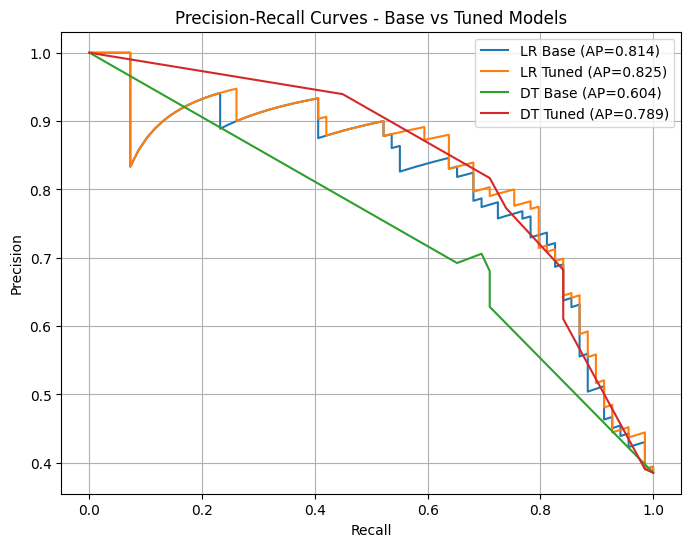

In [ ]:
plt.figure(figsize=(8,6))

#Logistic Regression

precision_lr_base,recall_lr_base,_ = precision_recall_curve(Y_test,lr_base_pred_prob)
precision_lr_tuned,recall_lr_tuned,_ = precision_recall_curve(Y_test,lr_tuned_pred_prob)
ap_lr_base = average_precision_score(Y_test,lr_base_pred_prob)
ap_lr_tuned = average_precision_score(Y_test,lr_tuned_pred_prob)

plt.plot(recall_lr_base,precision_lr_base,label=f'LR Base (AP={ap_lr_base:.3f})')
plt.plot(recall_lr_tuned,precision_lr_tuned,label=f'LR Tuned (AP={ap_lr_tuned:.3f})')

# Decision Trees

precision_dt_base,recall_dt_base,_ = precision_recall_curve(Y_test,dt_base_pred_prob)
precision_dt_tuned,recall_dt_tuned,_ = precision_recall_curve(Y_test,dt_tuned_pred_prob)
ap_dt_base = average_precision_score(Y_test,dt_base_pred_prob)
ap_dt_tuned = average_precision_score(Y_test,dt_tuned_pred_prob)
plt.plot(recall_dt_base,precision_dt_base,label=f'DT Base (AP={ap_dt_base:.3f})')
plt.plot(recall_dt_tuned,precision_dt_tuned,label=f'DT Tuned (AP={ap_dt_tuned:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves - Base vs Tuned Models')
plt.legend()
plt.grid(True)
plt.show()


**Cross Validation scores (AUC and F1) for tuned models**

In [ ]:
cv_auc_lr = cross_val_score(lr_tuned,X_train,Y_train,cv=cv_strategy,scoring='roc_auc')
cv_f1_lr = cross_val_score(lr_tuned,X_train,Y_train,cv=cv_strategy,scoring='f1')


cv_auc_dt = cross_val_score(dt_tuned,X_train,Y_train,cv=cv_strategy,scoring='roc_auc')
cv_f1_dt = cross_val_score(dt_tuned,X_train,Y_train,cv=cv_strategy,scoring='f1')

cv_results_df = pd.DataFrame({
    'Model':['LR Tuned','DT Tuned'],
    'AUC_mean':[cv_auc_lr.mean(),cv_auc_dt.mean()],
    'AUC_std':[cv_auc_lr.std(),cv_auc_dt.std()],
    'F1_mean':[cv_f1_lr.mean(),cv_f1_dt.mean()],
    'F1_std':[cv_f1_lr.std(),cv_f1_dt.std()]
})

display(cv_results_df)

,Model,AUC_mean,AUC_std,F1_mean,F1_std
0,LR Tuned,0.867588,0.023131,0.767422,0.026648
1,DT Tuned,0.861788,0.029221,0.756027,0.040196
